In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots, redcells
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_15', 'blk':'4'})
VG11.append({'mname': 'VG11', 'datexp': '2024_10_16', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_01', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_04', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_05', 'blk':'3'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_15', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_10_15', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_10_16', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_11_23', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_15', 'blk':'3'})
VG15.append({'mname': 'VG15', 'datexp': '2024_10_16', 'blk':'2'})
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
VG15.append({'mname': 'VG15', 'datexp': '2024_11_01', 'blk':'3'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_15', 'blk': '4'},
 {'mname': 'VG11', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_01', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_04', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_05', 'blk': '3'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_15', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_10_15', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_23', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_15', 'blk': '3'},
 {'mname': 'VG15', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_11_01', 'blk': '3'}]

In [4]:
name, datexp, blk = VG11[0]['mname'], VG11[0]['datexp'], VG11[0]['blk']

In [5]:
ROOT_PATH = "Z:/data/PROC"
RET_PATH = "D:/retinotopy/aligned_xy/behav"
MDL_PATH = "C:/Users/labadmin/Documents/category-neural/data" # we don't have models there, so it will create a new one.

In [9]:
zscored = True
name, datexp, blk = VG11[0]['mname'], VG11[0]['datexp'], VG11[0]['blk']
m1 = utils.load_mouse(name, datexp, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, 
                      data_path=ROOT_PATH, ret_path=RET_PATH,  mdl_path=MDL_PATH)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
    .rename(columns = {'index':'frame'})
    .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
    .set_index('frame'))

green_channel = Path(ROOT_PATH).joinpath(name, datexp, blk, "suite2p")
m1.isred = redcells.get_redcells(green_channel) # the corrected redcells.npy
# lets filter out cells with low snr
m1.isred = m1.isred[m1._snr>=.25]
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1._snr = m1._snr[m1._snr>=.25]
# lets get the interpolated spks
if zscored == True: 
    m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)
else:
    m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = False, corridor_length=400)
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector) #trial_no dict
utils.compute_dprime(m1, discrimination_region = (0,125), corridor_length = 400, nogray = False) #dprime scores on 0,125
#utils.save_mouse(m1, compressed=False, mdl_path="D:\mouseobj")
clear_output(wait=True)

Checking if model object exists ...
Timeline with fname: Timeline_VG11_2024_10_15_4.mat not found, trying with fname: VG11_2024_10_15_4.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:50<00:00, 17.52s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_15_4_behav.npz
(28508, 2)
39 11681
interpolating 25932 neurons, 11643 frames to
the vector of distance with shape: (11643,)
neurons: 25932, trials: 345, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials


## Difference between cell types in fr and variance 

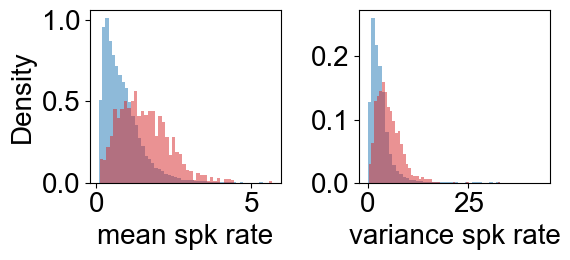

In [17]:
nn = m1.interp_spks.shape[0]
mean = m1._spks.mean(axis=1)
var = m1._spks.var(axis=1)

plt.figure(figsize=(6, 3))
ex = np.logical_not(m1.isred[:,0]).astype(bool)
inh = m1.isred[:,0].astype(bool)
plt.subplot(121)
plt.hist(mean[ex], bins=50, alpha=0.5, label='excitatory cells', color='tab:blue', density=True);
plt.hist(mean[inh], bins=50, alpha=0.5, label='inhibitory cells', color='tab:red', density=True);
plt.xlabel("mean spk rate")
plt.ylabel("Density")
plt.subplot(122)
plt.hist(var[ex], bins=50, alpha=0.5, label='excitatory cells', color='tab:blue', density=True);
plt.hist(var[inh], bins=50, alpha=0.5, label='inhibitory cells', color='tab:red', density=True);
plt.xlabel("variance spk rate")
plt.tight_layout()

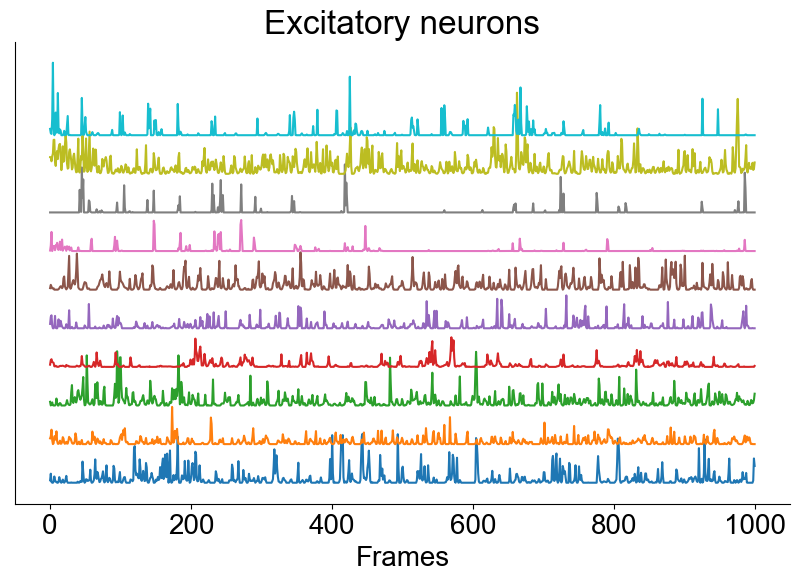

In [18]:
plt.figure(figsize=(10, 6))
# pick 10 random neurons and plot their spikes
ex_n = m1._spks[ex]
inh_n = m1._spks[inh]
neurons = np.random.choice(ex_n.shape[0], 10)
plt.title("Excitatory neurons")
for i, n in enumerate(neurons):
    plt.plot(ex_n[n,:1000] + (i) *10)
plt.xlabel('Frames')
plt.ylabel("")
plt.yticks([])
sns.despine()
plt.show()

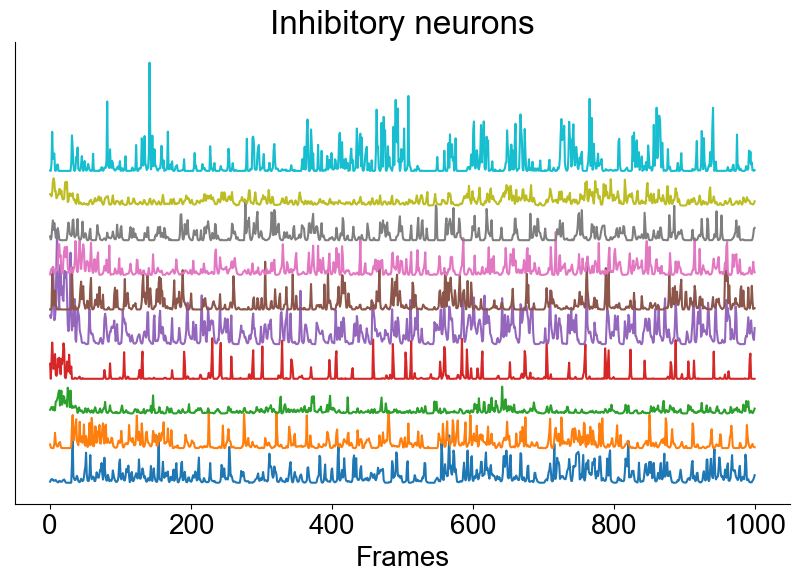

In [19]:
plt.figure(figsize=(10, 6))
neurons = np.random.choice(inh_n.shape[0], 10)
plt.title("Inhibitory neurons")
for i, n in enumerate(neurons):
    plt.plot(inh_n[n,:1000] + (i) *10)
plt.xlabel('Frames')
plt.ylabel("")
plt.yticks([])
sns.despine()
plt.show()

# Looks good, lets build all the objs that will be reutilized later, this process takes a while, but will save a lot of time later

In [20]:
for sess in all_sessions:
    name, datexp, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, datexp, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, 
                        data_path=ROOT_PATH, ret_path=RET_PATH,  mdl_path=MDL_PATH)
    frameselector = utils.get_frameselector(m1)
    istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
    istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
    m1.frameselector = (frameselector.reset_index()
        .rename(columns = {'index':'frame'})
        .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
        .set_index('frame'))

    green_channel = Path(ROOT_PATH).joinpath(name, datexp, blk, "suite2p")
    m1.isred = redcells.get_redcells(green_channel) # the corrected redcells.npy
    # lets filter out cells with low snr
    m1.isred = m1.isred[m1._snr>=.25]
    m1._spks = m1._spks[m1._snr>=.25]
    m1._xpos = m1._xpos[m1._snr>=.25]
    m1._ypos = m1._ypos[m1._snr>=.25]
    m1._iplane = m1._iplane[m1._snr>=.25]
    m1.iarea = m1.iarea[m1._snr>=.25]
    m1.iregion = m1.iregion[m1._snr>=.25]
    m1.xy_t = m1.xy_t[m1._snr>=.25]
    m1._snr = m1._snr[m1._snr>=.25]
    m1.trial_dict = utils.get_trialno_bytype(m1.frameselector) #trial_no dict
    # lets get the interpolated spks
    for zscored in [True, False]:
        if zscored == True:
            print("saving zscored version") 
            m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)
            save_path = r"D:\mouseobj"
            utils.compute_dprime(m1, discrimination_region = (0,125), corridor_length = 400, nogray = False)
        else:
            print("saving not zscored version") 
            m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = False, corridor_length=400)
            save_path = r"D:\mouseobj\notz"
            utils.compute_dprime(m1, discrimination_region = (0,125), corridor_length = 400, nogray = False)
        utils.save_mouse(m1, compressed=False, mdl_path=save_path)
    clear_output(wait=True)

Checking if model object exists ...
Timeline with fname: Timeline_VG15_2024_11_01_3.mat not found, trying with fname: VG15_2024_11_01_3.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:13<00:00, 15.66s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG15_2024_11_01_3_behav.npz
(23298, 2)
saving zscored version
39 14749
interpolating 20669 neurons, 14711 frames to
the vector of distance with shape: (14711,)
neurons: 20669, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG15\2024_11_01\3
saving not zscored version
39 14749
interpolating 20669 neurons, 14711 frames to
the vector of distance with shape: (14711,)
neurons: 20669, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\notz\VG15\2024_11_01\3


# now let's create the coding directions and splitting them into correct and incorrect
## coding directions

In [36]:
def compute_coding_dirs(name, date, blk):
    areas = ["V1", "medial", "lateral", "anterior"]
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    interp_spks = m1.interp_spks - m1.interp_spks.mean(1, keepdims=True)
    utils.compute_dprime(m1, discrimination_region=(0,125), concatenate=False, remove_mean=False)
    ntrials = m1.interp_spks.shape[1]
    ncells = m1.interp_spks.shape[0]
    ctypes = 2
    cod_dirs = np.empty((ntrials, len(areas), ctypes, 400)) #ntrials x areas x redcell x positions
    proportion = np.empty((len(areas), 2, 2))
    selective_cells = np.empty((4,2,2, ncells))
    main_dir = Path(f"../data/notz/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    for indexa, area in enumerate(areas):
        ia = utils.get_region_idx(m1.iarea, area)
        for redcell in range(ctypes):
            if redcell == 0: 
                selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
            else:
                selected_type = m1.isred[:,0].astype(bool)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = interp_spks[area_prefer_r] - interp_spks[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            cod_dirs[:, indexa, redcell, :] = avg_dir
            selective_cells[indexa, redcell, 0, :] = area_prefer_r
            selective_cells[indexa, redcell, 1, :] = area_prefer_nr
            # proportion of cells changing 
            prefer_r_1 = (m1.train_dp>=1)
            prefer_nr_1 = (m1.train_dp<=-1)
            area_prefer_r_1 = prefer_r_1 * ia * selected_type
            area_prefer_nr_1 = prefer_nr_1 * ia * selected_type
            proportion[indexa,redcell,0] = (area_prefer_r_1.sum()) / (ia * selected_type).sum()
            proportion[indexa,redcell,1] = (area_prefer_nr_1.sum()) / (ia * selected_type).sum()
    np.save(main_dir / "cod_dirs_0_125.npy", cod_dirs)
    np.save(main_dir / "selective_cells_0_125.npy", selective_cells)
    np.save(main_dir / "proportion_cells_0_125_1tsh.npy", proportion)

In [37]:
for sess in all_sessions:
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    compute_coding_dirs(name, date, blk)
    clear_output(wait=True)
print("Proccessing done")

Proccessing done


In [42]:
lick_response = np.empty((16, 4, 4, 2, 2), dtype=object)
for iss, sess in enumerate(all_sessions):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    pth = Path(fr"..\data\notz\{name}\{date}\{blk}\cod_dirs_0_125.npy")
    cod_dirs = np.load(pth)
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):
        t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=ttype, onlytest=True)
        cod_dir_licks = cod_dirs[t_licks]
        cod_dir_no_licks = cod_dirs[t_no_licks] 
        for area in range(4): 
            for ctype in range(2):
                lick_response[iss,i_t,area,ctype,0] = cod_dir_licks[:, area, ctype, :]
                lick_response[iss,i_t,area,ctype,1] = cod_dir_no_licks[:, area, ctype, :]
    clear_output(wait=True)
np.save(f"../data/notz/overall/cod_dir_splitted_with_wo_licks_pertrial_0_125.npy", lick_response)
print("Done")

Done
